# Challenge 2 - Custom Vision Cognitive Service
First create an account at https://customvision.ai
Then modify the service keys below:

In [1]:
TRAINING_KEY = 'YOUR_KEY'
PREDICTION_KEY = 'YOUR_KEY'
ENDPOINT='https://southcentralus.api.cognitive.microsoft.com' # If necessary, change to match your Azure service location

In [2]:
# Install the Custom Vision SDK
import sys
! {sys.executable} -m pip install azure-cognitiveservices-vision-customvision

    100% |████████████████████████████████| 102kB 4.6MB/s a 0:00:011
    100% |████████████████████████████████| 81kB 16.9MB/s ta 0:00:01
  Using cached https://files.pythonhosted.org/packages/56/9d/1d02dd80bc4cd955f98980f28c5ee2200e1209292d5f9e9cc8d030d18655/certifi-2018.10.15-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/ff/17/5cbb026005115301a8fb2f9b0e3e8d32313142fe8b617070e7baad20554f/requests-2.20.1-py2.py3-none-any.whl
    100% |████████████████████████████████| 51kB 17.3MB/s ta 0:00:01
  Using cached https://files.pythonhosted.org/packages/bc/a9/01ffebfb562e4274b6487b4bb1ddec7ca55ec7510b22e4c51f14098443b8/chardet-3.0.4-py2.py3-none-any.whl
    100% |████████████████████████████████| 122kB 20.3MB/s ta 0:00:01
  Found existing installation: requests 2.14.2
    Uninstalling requests-2.14.2:
      Successfully uninstalled requests-2.14.2


## Create a Custom Vision project

In [3]:
from azure.cognitiveservices.vision.customvision.training import CustomVisionTrainingClient

trainer = CustomVisionTrainingClient(TRAINING_KEY, endpoint=ENDPOINT)

# Create a new project
print ("Creating project...")
project = trainer.create_project("Adventure Works")

Creating project...


## Add tags

In [4]:
# Make two tags in the new project
hardshell_tag = trainer.create_tag(project.id, "Hardshell Jacket")
insulated_tag = trainer.create_tag(project.id, "Insulated Jacket")
print('Created tags')

Created tags


## Upload training images

In [5]:
import os
# Get the first 100 hardshell jacket images
hardshell_dir = "resized_images/hardshell_jackets"
for image in os.listdir(hardshell_dir)[0:99]:
    with open(os.path.join(hardshell_dir,image), mode="rb") as img_data: 
        trainer.create_images_from_data(project.id, img_data.read(), [hardshell_tag.id])

# Get the first 100 insulated jacket images
insulated_dir = "resized_images/insulated_jackets"
for image in os.listdir(insulated_dir)[0:99]:
    with open(os.path.join(insulated_dir, image), mode="rb") as img_data: 
        trainer.create_images_from_data(project.id, img_data.read(), [insulated_tag.id])
        
print('Added images.')

Added images.


## Train the project

In [6]:
import time

print ("Training...")
# Train the project, checking status every 1 second
iteration = trainer.train_project(project.id)
while (iteration.status == "Training"):
    iteration = trainer.get_iteration(project.id, iteration.id)
    print ("Training status: " + iteration.status)
    time.sleep(1)

# When the project is trained, make this iteration the default endpoint
trainer.update_iteration(project.id, iteration.id, is_default=True)
print ("Done!")

Training...
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Completed
Done!


## Use the project to classify test images

In [9]:
def classify_image(img):
    from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient
    from azure.cognitiveservices.vision.customvision.prediction import models

    predictor = CustomVisionPredictionClient(PREDICTION_KEY, endpoint=ENDPOINT)
    
    with open(img, 'rb') as f:
        img_data = f.read()
    
    try:
        # Get the predicted tags
        results = predictor.predict_image(project.id, img_data)
        return results.predictions[0].tag_name
    
    except Exception as e:
        print(e)


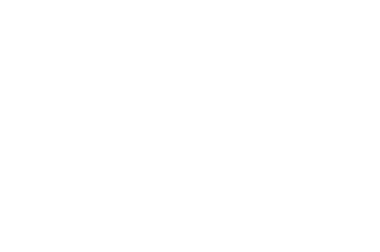

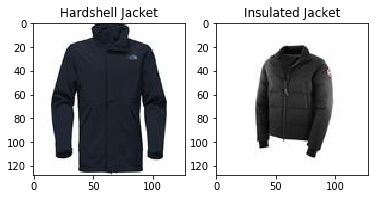

In [10]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time

plt.axis('off')

fig = plt.figure(figsize=(6, 6))

# Get the last image of each jacket type to test with
test_images = []
hardshell_dir = "resized_images/hardshell_jackets"
for image in os.listdir(hardshell_dir)[-1:]:
    test_images.append(os.path.join(hardshell_dir, image))
insulated_dir = "resized_images/insulated_jackets"
for image in os.listdir(insulated_dir)[-1:]:
    test_images.append(os.path.join(insulated_dir,image))
    
i = 0
for image in test_images:
    i = i + 1
    class_name = classify_image(image)
    img = mpimg.imread(image)
    a=fig.add_subplot(1,len(test_images),i)
    imgplot = plt.imshow(img)
    a.set_title(class_name)
    # Delay to avoid rate limit error
    time.sleep(1)

